<a href="https://colab.research.google.com/github/lastsupper108/Keras-tutorial/blob/master/gan_manoj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iter99Gen loss: 0.57201827
Iter99Dis loss: 1.2640947


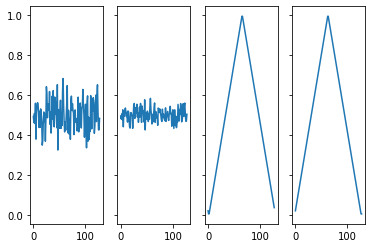

Iter199Gen loss: 0.6080198
Iter199Dis loss: 1.175997


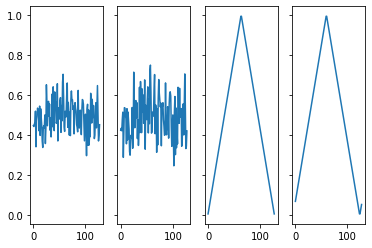

Iter299Gen loss: 0.61596394
Iter299Dis loss: 1.1529046


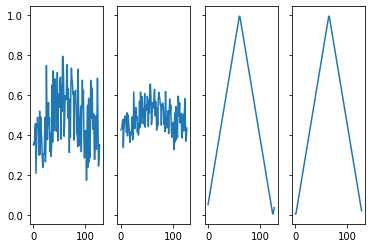

Iter399Gen loss: 0.61707234
Iter399Dis loss: 1.1648885


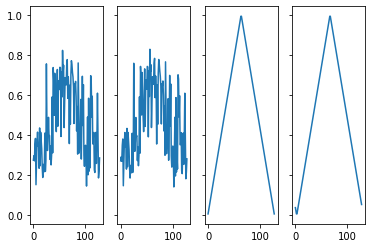

Iter499Gen loss: 0.5824685
Iter499Dis loss: 1.2459736


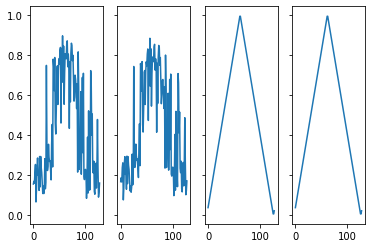

Iter599Gen loss: 0.5597733
Iter599Dis loss: 1.3280998


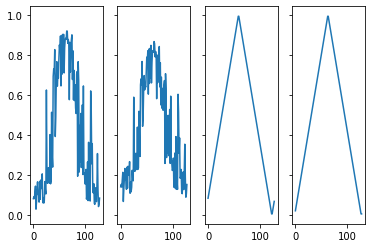

Iter699Gen loss: 0.5744064
Iter699Dis loss: 1.3841915


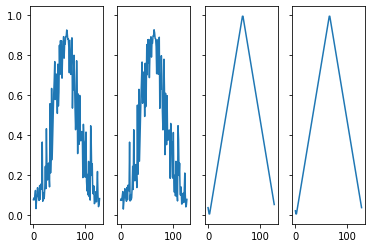

Iter799Gen loss: 0.67144346
Iter799Dis loss: 1.4008702


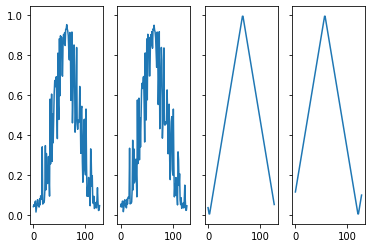

Iter899Gen loss: 0.68819296
Iter899Dis loss: 1.3903487


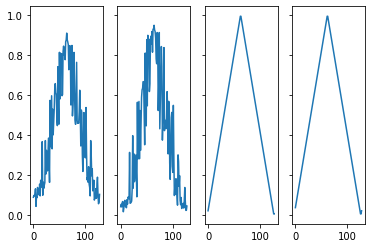

Iter999Gen loss: 0.69067514
Iter999Dis loss: 1.3884115


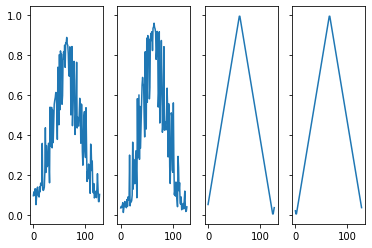

Iter1099Gen loss: 0.6914594
Iter1099Dis loss: 1.3877981


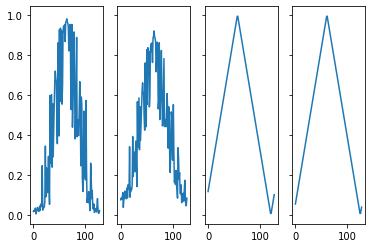

Iter1199Gen loss: 0.69196963
Iter1199Dis loss: 1.3873572


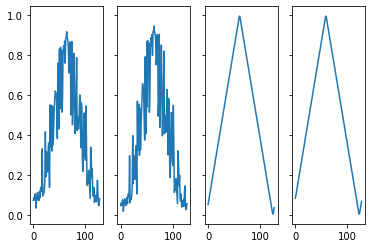

Iter1299Gen loss: 0.6922207
Iter1299Dis loss: 1.3871458


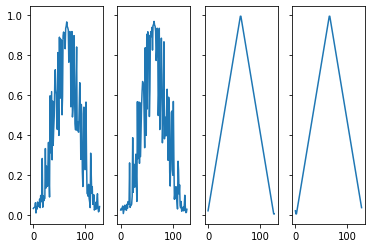

Iter1399Gen loss: 0.6924465
Iter1399Dis loss: 1.386941


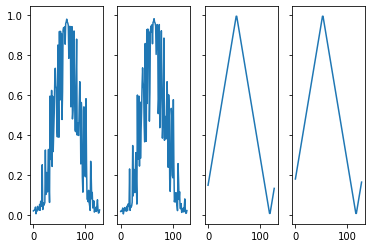

Iter1499Gen loss: 0.6925444
Iter1499Dis loss: 1.3868572


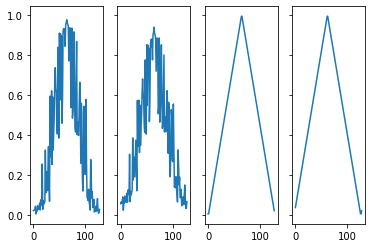

Iter1599Gen loss: 0.6926363
Iter1599Dis loss: 1.3867757


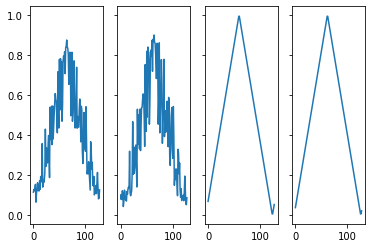

Iter1699Gen loss: 0.69272673
Iter1699Dis loss: 1.3866909


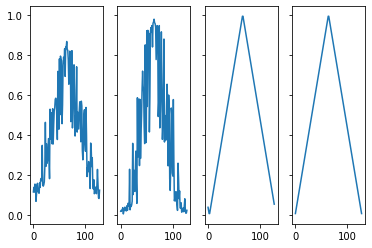

Iter1799Gen loss: 0.6927907
Iter1799Dis loss: 1.3866317


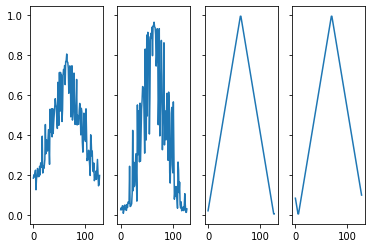

Iter1899Gen loss: 0.6928334
Iter1899Dis loss: 1.3865929


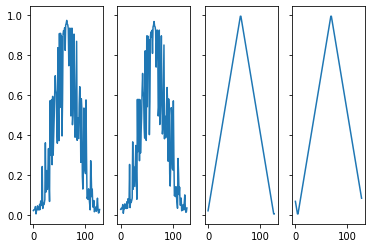

Iter1999Gen loss: 0.6928804
Iter1999Dis loss: 1.3865486


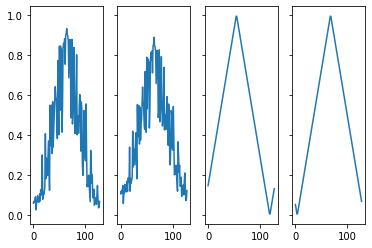

In [76]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
### 1D traiangle data generation ###
DisInputLength= 128
GenInputLenght =5
batch_size = 128
#learning_rate = 5e-6 
learning_rate = 5e-5 
num_training_iterations= 2000

def get_Gen_inp(InputLenght,batch):
	return np.random.rand(batch,InputLenght)

def get_Dist_real(Lenght,batch):
	normal_shift = (np.random.normal(0,5,batch)).astype(int)
	wave = signal.triang(Lenght)
	x_input = np.array([np.roll(wave,x) for x in normal_shift])
	return x_input

def build_Gen_small(GenInputLenght,DisInputLength):
  model = tf.keras.Sequential(\
  	[tf.keras.layers.Dense(4,input_shape=[GenInputLenght])\
    ,tf.keras.layers.Dropout(0.5)\
  	,tf.keras.layers.Dense(20)\
    ,tf.keras.layers.Dropout(0.5)\
  	,tf.keras.layers.Dense(60)\
  	,tf.keras.layers.Dense(DisInputLength,activation='sigmoid')])
  return model

def build_Dis_small(DisInputLength):
  model = tf.keras.Sequential(\
  	[tf.keras.layers.Dense(60,input_shape=[DisInputLength])\
    ,tf.keras.layers.Dense(20)\
  	,tf.keras.layers.Dense(4)\
  	,tf.keras.layers.Dense(1,activation='sigmoid')])
  return model

def build_Gen(GenInputLenght,DisInputLength):
  model = tf.keras.Sequential(\
  	[tf.keras.layers.Dense(4,input_shape=[GenInputLenght])\
  	,tf.keras.layers.Dense(8)\
    ,tf.keras.layers.Dropout(0.5)\
  	,tf.keras.layers.Dense(16)\
    ,tf.keras.layers.Dropout(0.5)\
    ,tf.keras.layers.Dense(32)\
    ,tf.keras.layers.Dense(50)\
    ,tf.keras.layers.Dropout(0.5)\
  	,tf.keras.layers.Dense(75)\
  	,tf.keras.layers.Dense(DisInputLength)])
  return model

def build_Dis(DisInputLength):
  model = tf.keras.Sequential(\
  	[tf.keras.layers.Dense(75,input_shape=[DisInputLength])\
    ,tf.keras.layers.Dense(50)\
  	,tf.keras.layers.Dense(32)\
  	,tf.keras.layers.Dense(16)\
    ,tf.keras.layers.Dense(8)\
  	,tf.keras.layers.Dense(4)\
  	,tf.keras.layers.Dense(1,activation='sigmoid')])
  return model


Gen = build_Gen_small(GenInputLenght,DisInputLength)
Dis = build_Dis_small(DisInputLength)
optimizer_gen = tf.keras.optimizers.Adam(learning_rate)
optimizer_dis = tf.keras.optimizers.Adam(learning_rate)


checkpoint_dir_gen = './'
checkpoint_prefix = os.path.join(checkpoint_dir_gen, "my_ckpt_gen")

checkpoint_dir_dis = './'
checkpoint_prefix = os.path.join(checkpoint_dir_dis, "my_ckpt_dis")


def compute_loss(labels, pred):
	loss = tf.keras.losses.binary_crossentropy(labels, pred)
	return loss

'''
def compute_loss_dis(pred_x, pred_z):
	loss = tf.math.reduce_sum( tf.math.log(1-pred_x) + tf.math.log(pred_z) )
	return loss
'''
def compute_loss_gen(pred):
	loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(pred), pred)
	return loss

def compute_loss_dis(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

@tf.function
def train_step_DisOnly(gen_x, dis_real_x ): 
  with tf.GradientTape() as tape:
    dis_fake_x = Gen(gen_x)
    pred_z = Dis(dis_fake_x)
    pred_x = Dis(dis_real_x)

    #print(tf.squeeze(dis_pred).numpy(),dis_y)
    loss = discriminator_loss(pred_x,pred_z)

  #print(np.shape(loss_gen.numpy()),np.shape(loss_dis.numpy()))
  #print(loss_dis.numpy())
  grads = tape.gradient(loss, Dis.trainable_variables)
  optimizer_dis.apply_gradients(zip(grads, Dis.trainable_variables))

  return loss

def run_dif():
  hist =[]
  #### training ########
  for iter in range(num_training_iterations):
    dis_fake_x = get_Gen_inp(GenInputLenght,batch_size)
    dis_real_x = get_Dist_real(DisInputLength,batch_size)

    loss = train_step_DisOnly(dis_fake_x,dis_real_x)
    hist.append(loss)
    
    if(iter%200 == 0):
      print('Iter'+str(iter)+'loss:',loss.numpy().mean())
      inp1= get_Gen_inp(DisInputLength,1)
      plt.plot(inp1[0])
      out = Dis(inp1)
      print('out1:',out)

      inp2= get_Dist_real(DisInputLength,1)
      plt.plot(inp2[0])
      out = Dis(inp2)
      print('out2:',out)
      plt.pause(0.05)
  return hist

#hist = run_dif()



@tf.function
def train_step(gen_x, dis_real_x ): 
  with tf.GradientTape() as tape:
    dis_fake_x = Gen(gen_x)
    pred_z = Dis(dis_fake_x)
    pred_x = Dis(dis_real_x)
    #print(tf.squeeze(dis_pred).numpy(),dis_y)
    loss_dis = compute_loss_dis(pred_x,pred_z)

  #print(np.shape(loss_gen.numpy()),np.shape(loss_dis.numpy()))
  #print(loss_dis.numpy())
  grads_dis = tape.gradient(loss_dis, Dis.trainable_variables)
  optimizer_dis.apply_gradients(zip(grads_dis, Dis.trainable_variables))
  

  with tf.GradientTape() as tape:
    gen_output = Gen(gen_x)
    dis_fake_out = Dis(gen_output)
    loss_gen = compute_loss_gen(tf.squeeze(dis_fake_out))

  grads_gen = tape.gradient(loss_gen, Gen.trainable_variables)
  optimizer_gen.apply_gradients(zip(grads_gen, Gen.trainable_variables))

  return loss_dis,loss_gen


def run_my_gan():
  hist_dis =[]
  hist_gen = []

  #### training ########
  for iter in range(num_training_iterations):
    gen_x = get_Gen_inp(GenInputLenght,batch_size)
    dis_real_x = np.float32(get_Dist_real(DisInputLength,batch_size))


    loss_dis,loss_gen = train_step(gen_x,dis_real_x)
    hist_gen.append(loss_gen)
    hist_dis.append(loss_dis)
    if((iter+1)%100 == 0):
      print('Iter'+str(iter)+'Gen loss:',loss_gen.numpy().sum())
      print('Iter'+str(iter)+'Dis loss:',loss_dis.numpy().sum())
      out = Gen(get_Gen_inp(GenInputLenght,2))
      inp =  get_Dist_real(DisInputLength,2)
      fig,(ax1, ax2, x1, x2) = plt.subplots(1, 4, sharey=True)

      ax1.plot(out[0])
      ax2.plot(out[1])

      x1.plot(inp[0])
      x2.plot(inp[1])
      plt.pause(0.05)
  return hist_gen,hist_dis

h_g,h_d = run_my_gan()

# New Section

(2000,) (2000,) [<tf.Tensor: shape=(), dtype=float32, numpy=1.4029303>, <tf.Tensor: shape=(), dtype=float32, numpy=1.4006085>, <tf.Tensor: shape=(), dtype=float32, numpy=1.4013109>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3991677>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3991804>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3963276>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3957763>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3957279>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3940065>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3924434>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3925263>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3922405>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3895965>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3892218>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3875228>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3862581>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3852215>, <tf.Tensor: shape=(), dtype=float32, numpy=1.383

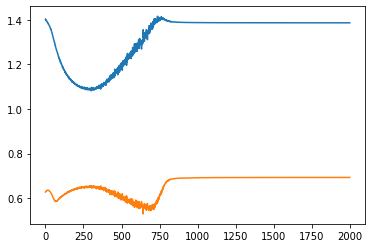

In [74]:

plt.plot(h_d)
plt.plot(h_g)
print(np.shape(h_g),np.shape(h_d),h_d[0:52])

tf.Tensor(
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]], shape=(1, 128), dtype=float32)


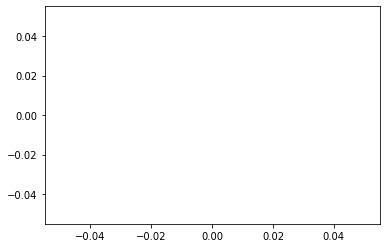

[<tf.Tensor: shape=(), dtype=float32, numpy=-298.623>, <tf.Tensor: shape=(), dtype=float32, numpy=-298.71103>, <tf.Tensor: shape=(), dtype=float32, numpy=-293.227>, <tf.Tensor: shape=(), dtype=float32, numpy=-291.8582>, <tf.Tensor: shape=(), dtype=float32, numpy=-286.10626>, <tf.Tensor: shape=(), dtype=float32, numpy=-301.22333>, <tf.Tensor: shape=(), dtype=float32, numpy=-291.17676>, <tf.Tensor: shape=(), dtype=float32, numpy=-286.3735>, <tf.Tensor: shape=(), dtype=float32, numpy=-293.65738>]


In [0]:
inp1 = get_Gen_inp(5,1)
out = Gen(inp1)
print(out)
plt.plot(out)
plt.pause(0.05)

print(h_d[1:10])